In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../python/')

# Liège city dataset

In [2]:
import json
import random
import via as VIA

from torch.utils.data import DataLoader
from dataset import VIADataset, RandomTranspose, ToTensor

path = '../products/liege/'
via = VIA.load('../resources/walonmap/via_liege_city.json')

keys = sorted(list(via.keys()))

random.seed(0)
random.shuffle(keys)

valid_via = {key: via[key] for i, key in enumerate(keys) if (i % 5) == 0} # fold 0
validset = ToTensor(VIADataset(valid_via, path, shuffle=True, size=512))
validloader = DataLoader(validset, batch_size=5)

# Model

The selected model is a **Multi-Task U-Net** trained for `20` epochs on the whole californian dataset. The Californian images have been up-scaled by a factor `2` to match the WalOnMap scale.

It was then *fine tuned* for `10` more epochs on the WalOnMap dataset.

In [3]:
import torch
from models import MultiTaskUNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
before = MultiTaskUNet(3, 1, R=5).to(device)
before.load_state_dict(torch.load('../products/models/multiunet_x2_020.pth', map_location=device))

after = MultiTaskUNet(3, 1, R=5).to(device)
after.load_state_dict(torch.load('../products/models/multiunet_x2_0_030.pth', map_location=device))

<All keys matched successfully>

## Sample

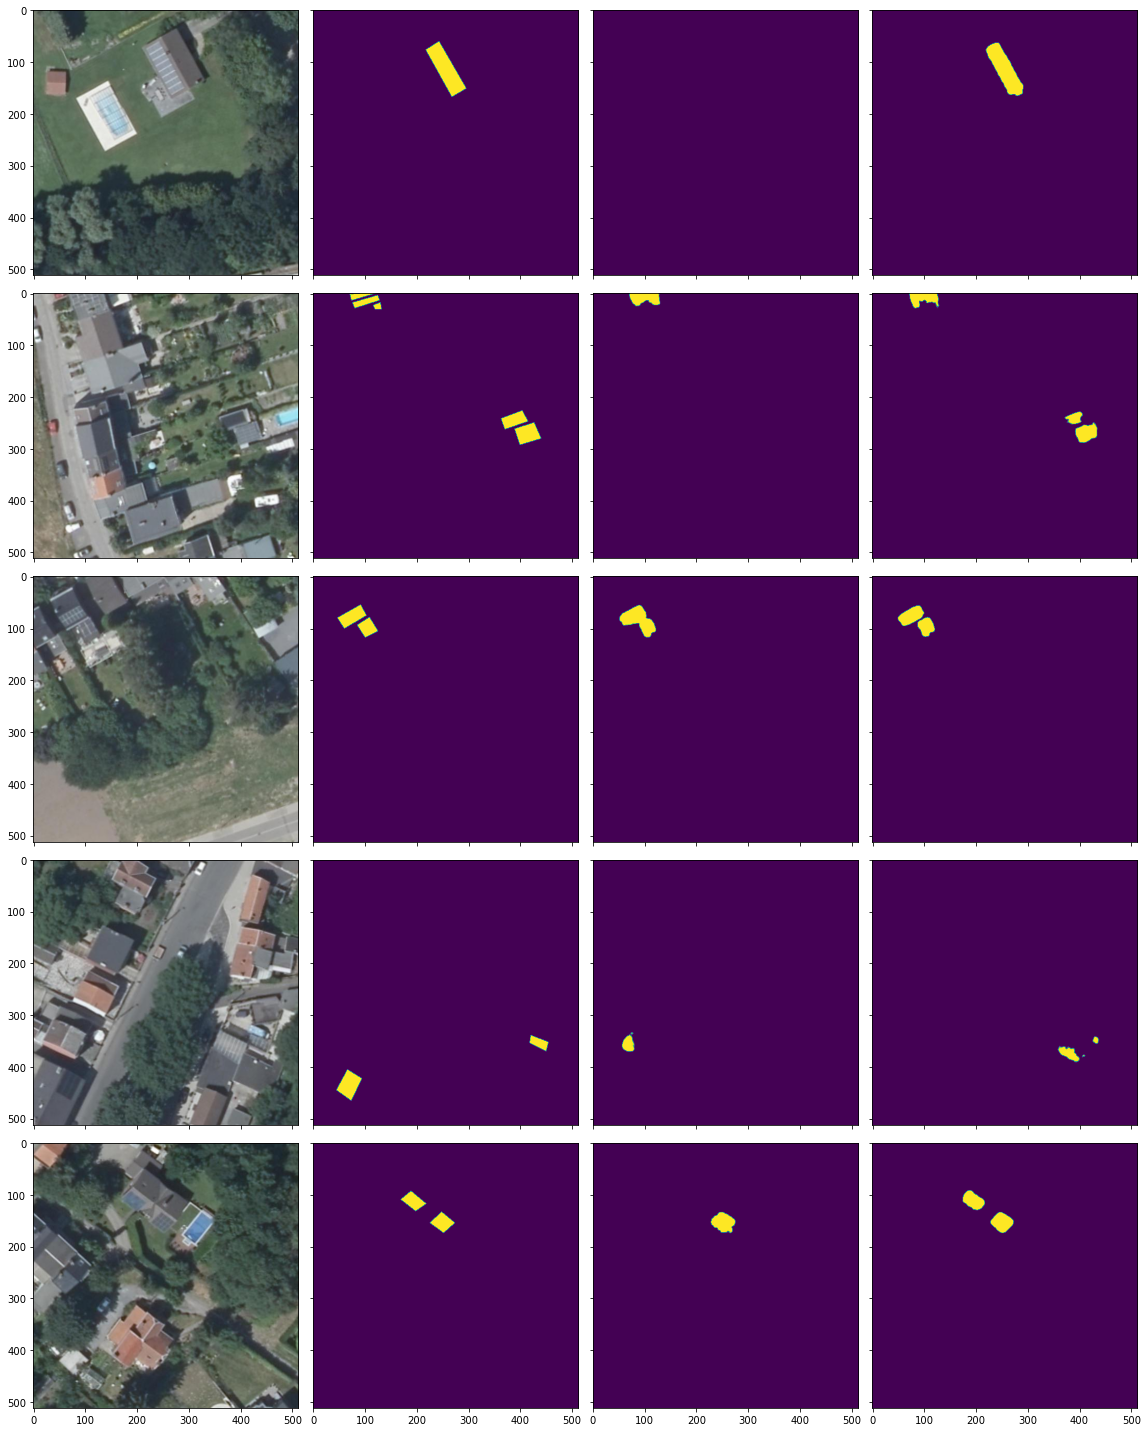

In [4]:
import matplotlib.pyplot as plt

from dataset import to_pil
from plots import plot_alongside

before.eval()
after.eval()

with torch.no_grad():
    for inputs, targets in validloader:
        break

    inputs = inputs.to(device)
    b_outputs = before(inputs).cpu()
    a_outputs = after(inputs).cpu()

plot_alongside(
    map(to_pil, inputs.cpu()),
    map(to_pil, targets),
    map(to_pil, b_outputs),
    map(to_pil, a_outputs)
)

plt.tight_layout()